# Моделирование молекул с помощью VQE

В этом практикуме представлен вариационный квантовый алгоритм для нахождения основных состояний (VQE), мотивируем его использование, объясняем необходимую теорию и демонстрируем его реализацию для нахождения энергии основного состояния молекул.

In [1]:
from qiskit import Aer, transpile, assemble
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 10000

## Пример вариационной формы

Сначала мы создаем случайный вектор вероятности в python:

In [2]:
import numpy as np
np.random.seed(999999)
target_distr = np.random.rand(2)
# Теперь мы преобразуем случайный вектор в валидный вектор вероятности
target_distr /= sum(target_distr)

Затем мы создаем функцию, которая принимает параметры нашей единственной вариационной формы U3 в качестве аргументов и возвращает соответствующую квантовую схему:

In [3]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
def get_var_form(params):
    qr = QuantumRegister(1, name="q")
    cr = ClassicalRegister(1, name='c')
    qc = QuantumCircuit(qr, cr)
    qc.u(params[0], params[1], params[2], qr[0])
    qc.measure(qr, cr[0])
    return qc

Теперь мы указываем целевую функцию, которая принимает в качестве входных данных список параметров вариационной формы и возвращает минимизируемое значение:

In [4]:

def get_probability_distribution(counts):
    output_distr = [v / NUM_SHOTS for v in counts.values()]
    if len(output_distr) == 1:
        output_distr.append(1 - output_distr[0])
    return output_distr

def objective_function(params):
    # Получим circuit из параметров
    qc = get_var_form(params)
    # Запустим circuit, чтобы получить распределение вероятностей, связанное с текущими параметрами.
    t_qc = transpile(qc, backend) # Транспилляция
    qobj = assemble(t_qc, shots=NUM_SHOTS)
    result = backend.run(qobj).result()
    # Получите значения каунтов для каждого измеренного состояния и преобразуем в вектор вероятности.
    output_distr = get_probability_distribution(result.get_counts(qc))
    # Посчитаем расстояние между выходным распределением и целевым распределением
    cost = sum([np.abs(output_distr[i] - target_distr[i]) for i in range(2)]) # Манхеттенская метрика
    return cost

Наконец, мы создаем экземпляр оптимизатора COBYLA и запускаем алгоритм. Обратите внимание, что выходные данные варьируются от запуска к запуску. Более того, хотя и близкое, полученное распределение может не совпадать с целевым распределением, однако увеличение NUM_SHOTS повысит точность выходных данных.

In [5]:
from qiskit.aqua.components.optimizers import COBYLA

# Инициализируем оптимизатор COBYLA
optimizer = COBYLA(maxiter=500, tol=0.0001)

# Зададим начальные параметры (обратите внимание, что наша вариационная форма с одним кубитом имеет 3 параметра)
params = np.random.rand(3)
ret = optimizer.optimize(num_vars=3, objective_function=objective_function, initial_point=params)

# Получим выходное распределение, используя окончательные параметры
qc = get_var_form(ret[0])
t_qc = transpile(qc, backend)
qobj = assemble(t_qc, shots=NUM_SHOTS)
counts = backend.run(qobj).result().get_counts(qc)
output_distr = get_probability_distribution(counts)

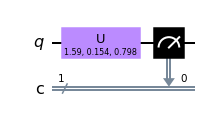

In [6]:
qc.draw('mpl')

In [7]:
print("Target Distribution:", target_distr)
print("Obtained Distribution:", output_distr)
print("Output Error (Manhattan Distance):", ret[1])
print("Parameters Found:", ret[0])

Target Distribution: [0.51357006 0.48642994]
Obtained Distribution: [0.5062, 0.4938]
Output Error (Manhattan Distance): 0.003340118738839104
Parameters Found: [1.59223137 0.15424275 0.79757013]


## Структура часто используемых вариационных форм

=============Linear Entanglement:=============


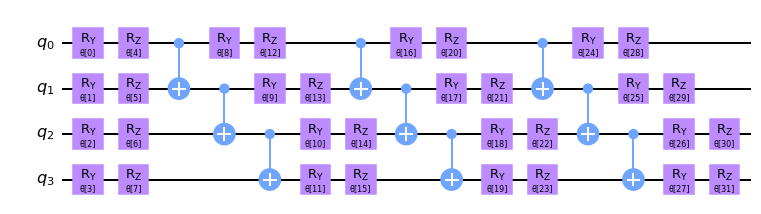


=============Full Entanglement:=============


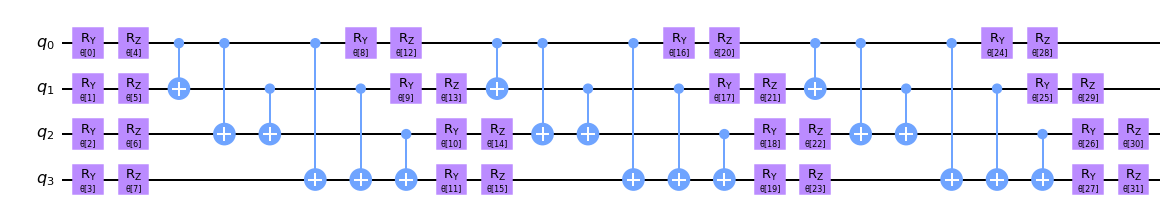

In [8]:
from qiskit.circuit.library import EfficientSU2
entanglements = ["linear", "full"]
for entanglement in entanglements:
    form = EfficientSU2(num_qubits=4, entanglement=entanglement)
    if entanglement == "linear":
        print("=============Linear Entanglement:=============")
    else:
        print("=============Full Entanglement:=============")
    display(form.decompose().draw('mpl', fold=100))
    print()

## Реализация VQE в Qiskit
В этом разделе показана реализация VQE.

In [9]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

### VQE на Statevector симуляторе

Мы произведем расчет энергии основного состояния для LiH (гидрид лития) на различных межатомных расстояниях. На каждом таком расстоянии должен быть создан драйвер для молекулы. 

В этом эксперименте, чтобы уменьшить количество используемых кубитов, мы замораживаем ядро и удаляем две незанятые орбитали. 

Во-первых, мы определяем функцию, которая принимает межатомное расстояние и возвращает соответствующий гамильтониан, $H$, а также некоторую другую информацию об операторе.

In [10]:
def get_qubit_op(dist):
    driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

Во-первых, точная энергия основного состояния вычисляется с использованием оператора кубита и классического точного алгоритма. 

Затем создается начальное состояние $|\psi\rangle$, которое экземпляр VQE использует для создания окончательного анзаца $\min_{\theta}(|\psi(\theta)\rangle)$. Точный результат и результат VQE для каждого межатомного расстояния сохраняются. 

Обратите внимание, что результат, полученный с помощью `VQE(qubitOp, var_form, optimizer, 'matrix')`, эквивалентен величине $\min_{\theta}\left(\langle \psi(\theta)|H|\psi(\ theta)\rangle\right)$, где минимум не обязательно является глобальным минимумом.

При инициализации экземпляра VQE с помощью `VQE(qubitOp, var_form, optimizer, 'paulis')` ожидаемое значение $H$ на $|\psi(\theta)\rangle$ напрямую вычисляется посредством умножения матриц. Однако при использовании реального квантового устройства или настоящего симулятора, такого как qasm_simulator с VQE(qubitOp, var_form, optimizer, 'paulis') , расчет ожидаемого значения более сложен. Гамильтониан может быть представлен как сумма строк Паули, где каждый член Паули действует на кубит, как указано используемым отображением. Каждая струна Паули имеет соответствующую схему, присоединенную к схеме, соответствующей $|\psi(\theta)\rangle$. Затем выполняется каждый circuit, и все результаты используются для определения математического ожидания $H$ на $|\psi(\theta)\rangle$. 

В следующем примере мы инициализируем экземпляр VQE в «матричном» режиме, поэтому ожидаемое значение вычисляется напрямую посредством матричного умножения.

Обратите внимание, что выполнение следующего фрагмента кода может занять несколько минут.

In [11]:
backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + shift)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    ) 
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
print("All energies have been calculated")

Interatomic Distance: 0.5 VQE Result: -7.039673441786052 Exact Energy: [-7.03973252]
Interatomic Distance: 0.6 VQE Result: -7.3133088813306655 Exact Energy: [-7.31334583]
Interatomic Distance: 0.7 VQE Result: -7.500887035387423 Exact Energy: [-7.50092209]
Interatomic Distance: 0.8 VQE Result: -7.6309454102357925 Exact Energy: [-7.63097825]
Interatomic Distance: 0.9 VQE Result: -7.720781099287972 Exact Energy: [-7.72081241]
Interatomic Distance: 1.0 VQE Result: -7.782211599258845 Exact Energy: [-7.7822424]
Interatomic Distance: 1.1 VQE Result: -7.823568080715006 Exact Energy: [-7.82359928]
Interatomic Distance: 1.2 VQE Result: -7.850666132481752 Exact Energy: [-7.85069838]
Interatomic Distance: 1.3 VQE Result: -7.867529586008669 Exact Energy: [-7.86756329]
Interatomic Distance: 1.4 VQE Result: -7.876966253807 Exact Energy: [-7.87700149]
Interatomic Distance: 1.5 VQE Result: -7.880979506945424 Exact Energy: [-7.88101572]
Interatomic Distance: 1.6 VQE Result: -7.881036616752466 Exact Ener

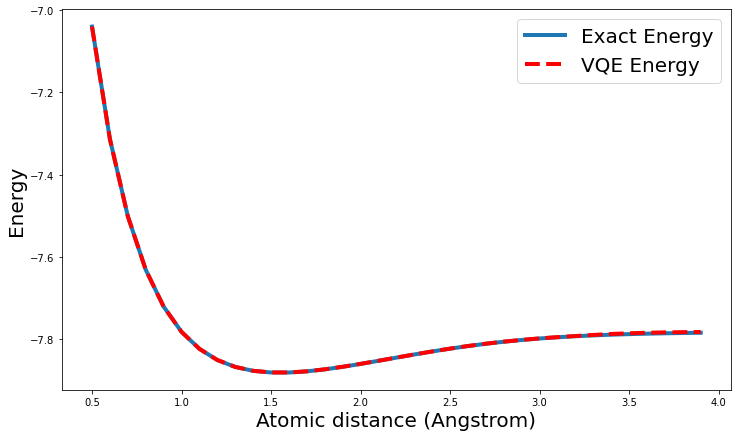

In [12]:
plt.figure(figsize=(12, 7))
plt.plot(distances, exact_energies, label="Exact Energy", linewidth=4)
plt.plot(distances, vqe_energies, '--', label="VQE Energy", linewidth=4, color='red')
plt.xlabel('Atomic distance (Angstrom)', fontsize=20)
plt.ylabel('Energy', fontsize=20)
plt.legend(fontsize=20)
plt.show()